In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import sys
sys.path.append('/Users/qnl/Documents/Vinay/QNL')

from qnl_ctrl.qnl_analysis import SimTools as ST

from importlib import reload

## How do you sample a uniform (pure) quantum state on a Hilbert space of dimension n?

Let's get intuition for this question by looking at the case where $n$ = 2.  A general qubit state is specified by four real numbers, 
\begin{equation}
|\psi\rangle = (x_0 + i y_0) |0\rangle + (x_1 + i y_1) |1\rangle
\end{equation}
but subject to the normalization constraint $x_0^2 + x_1^2 + y_0^2 + y_1^2 = 1$, and with the caveat that states which differ by an overall phase are the same quantum state.  

We want to specify a joint probability distribution for $x_0, x_1, y_0, y_1$ such that all pure states are equally likely.  Since any set of four numbers that satisfies normalization should be equally likely, we can just write 
\begin{equation}
p(x_0, y_0, x_1, y_1) = \mathcal{N}\delta(x_0^2 + x_1^2 + y_0^2 + y_1^2 - 1),
\end{equation}
where $\mathcal{N}$ is simply a normalization constant. This is true in higher dimensions as well.  But how do we sample from such a distribution?

As you might expect, the way to understand this sampling is to exploit geometric intuition, and think of what you're doing as sampling uniformly from the surface of the unit-sphere of dimension $2N$ (where $N$ is the dimension of the Hibert space, NOT the number of qubits).  Note that sampling from this distribution is not trivial since the variables $x_0, x_1, y_0, y_1$ are not independent (because of the normalization constraint, i.e. the sphere must have radius unity).  However, it turns out there's a nice trick to sample from a sphere of arbitrary dimension $M$:  you just generate $M$ independent, normally-distributed random variables and then normalize.  

It's probably worth spending a bit of time thinking through why this works, but numerically at least we can show that it works for the cases of $n = 2$ 

TODO: Implement 3D plotting to show that it also works for $n = 3$

In [3]:
# Show that it works for n = 2

def uniform_sphere_point(dimension = 2, num_points = 100):
    """ Generates a uniformly-sampled point from the surface of a unit-sphere with the specified dimension """
    
    initial_points = np.random.randn(dimension, num_points) # will not lie on the UNIT sphere, i.e. radius will be wrong
    
    # Normalize
    radii = np.sqrt(np.sum(initial_points**2, axis = 0))
    normalized_points = initial_points / radii
    return normalized_points

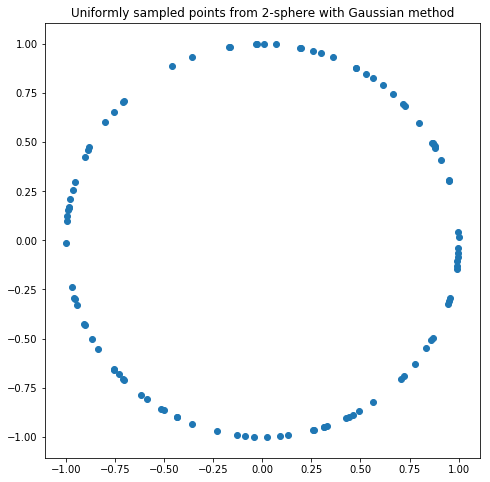

In [4]:
plt.figure(figsize = (8,8))
plt.scatter(*uniform_sphere_point())
plt.axis('square');
plt.title('Uniformly sampled points from 2-sphere with Gaussian method');

We will use this method to generate random pure states for arbitrary-dimensioned systems

## Property 1:  Uniform pure states on a bipartite system are almost always entangled

It turns out that if you generate a pure state of a bipartite (say, N x K dimensional) system, the states are almost always entangled.  One way to think about this is to think about the dimension of the space.  As we discussed earlier, pure states of the N x K dimensional system occupy the surface of a sphere with (2 x N x K - 2) dimensions.  Pure states of the N dimensional system occupy a sphere of $(2N - 2)$ dimensions, while pure states of the K dimensional system occupy a sphere of $(2K - 2)$ dimensions.  That means that the dimension of the set of of pure states in the N x K dimensional space is the sum of the above two dimensions, i.e. 2N + 2K - 4.  This is (always?) less than the dimenion of the full Hilbert space, which we said above was 2NK - 2.  

For example in the qubit-qubit case, where $N = K = 2$, the space of pure states is 4-dimensional, whereas the space of all states is 6-dimensional.  So if you uniformly sample from the 6-dimensional space, you'll almost never see a pure state. 

Let's do some numerics to investigate the entanglement entropy of a random qubit entangled with another system (i.e. a $2$ x $N$ dimensional) state, i.e. the entropy when you trace out the thing that's not the qubit.

In [136]:
n_states = 100
dim_sys1 = 2
dim_sys2 = 2
entropies = np.zeros(n_states)

for i in range(n_states):
    psi = ST.random_pure_state(dim_sys1*dim_sys2)
    rho = ST.vec_to_dm(psi)
    rho_reduced = ST.partial_trace(rho, dim = [dim_sys1, dim_sys2])
    entropies[i] = ST.entropy(rho_reduced)

In [137]:
np.mean(entropies), np.std(entropies)

(0.50918028039223051, 0.26521309715514269)

In [138]:
def avg_entropy(dim_sys1, dim_sys2, n_states = 100):
    """ returns the average entropy (averaged over n_states randomly-generated pure states of dimension dim_sys1*dim_sys2)
        of the reduced density matrix one obtains by tracing out system 2 """
    
    entropies = np.zeros(n_states)
    
    for i in range(n_states):
        psi = ST.random_pure_state(dim_sys1*dim_sys2)
        rho = ST.vec_to_dm(psi)
        rho_reduced = ST.partial_trace(rho, dim = [dim_sys1, dim_sys2])
        entropies[i] = ST.entropy(rho_reduced)
    
    return np.mean(entropies)

def avg_entropy_Page(dim_sys1, dim_sys2):
    """ returns the average entropy (calculated via Don Page's approximate formula) 
        for a pure state of dimension dim_sys1 * dim_sys2
        
        """
    
    return (np.log(dim_sys1) - dim_sys1/(2.*dim_sys2))/np.log(2)

In [139]:
dims_sys2 = np.arange(2, 11)
dim_sys1 = 2
qubit_entropies = [avg_entropy(dim_sys1, int(n), n_states = 1000) for n in dims_sys2]
qubit_entropies_Page = [avg_entropy_Page(dim_sys1, int(n)) for n in dims_sys2]

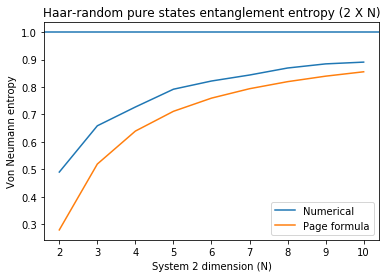

In [140]:
plt.plot(dims_sys2, qubit_entropies, label = 'Numerical')
plt.plot(dims_sys2, qubit_entropies_Page, label = 'Page formula')
plt.title('Haar-random pure states entanglement entropy ({} X N)'.format(dim_sys1))
plt.xlabel('System 2 dimension (N)')
plt.ylabel('Von Neumann entropy')
plt.legend(loc = 4)
plt.axhline(np.log2(dim_sys1))

### Two qubits: how entangled are they

In [61]:
avg_entropy(2,2, n_states = 10000)

0.48422185685387192

Let's see what sort of density matrix would have this sort of von Neumann entropy.  i.e. what should the off-diagonal terms be

In [77]:
sys_dim = 2
coherence = 0.8
dm = (np.eye(sys_dim) + coherence * np.array([[0,1],[1,0]]))/sys_dim

In [78]:
dm

array([[ 0.5,  0.4],
       [ 0.4,  0.5]])

In [79]:
ST.entropy(dm)

0.46899559358928156

So it looks like the generic value of the off diagonal element's magnitude is roughly 80 percent of the pure-state value

Now let's histogram the von Neumann entropies to see their spread

In [144]:
n_states = 100000
dim_sys1 = 2
dim_sys2 = 2

entropies = np.zeros(n_states)
    
for i in range(n_states):
    psi = ST.random_pure_state(dim_sys1*dim_sys2)
    rho = ST.vec_to_dm(psi)
    rho_reduced = ST.partial_trace(rho, dim = [dim_sys1, dim_sys2])
    entropies[i] = ST.entropy(rho_reduced)

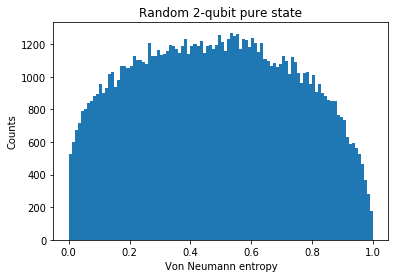

In [145]:
plt.hist(entropies, bins = 100);
plt.xlabel('Von Neumann entropy')
plt.ylabel('Counts')
plt.title('Random 2-qubit pure state');

In [156]:
qubit_2_entropy_distribution = np.histogram(entropies, bins=100, normed = True)

So it seems like in the 2-qubit case, we expect a spread of entanglement entropies.  It almost looks like the distribution of von Neumann entorpies is close to uniform between 0 and 1.  TODO: Is there an analytic way to get this result?  



#### Comparison with CNOT applied to random product states

Continuing with the 2-qubit case, if we generate a random product state and then apply a familiar two-qubit gate like a CNOT, what does the spread of entanglement entropies look like?  I wouldn't expect it to look as entangled as the Haar-random 2-qubit unitaries above (I guess another way to state that is that a product of 2 single-qubit Haar-random unitaries combined with a single CNOT should not itself be Haar-random), but let's check.

In [154]:
n_states = 100000
dim_sys1 = 2
dim_sys2 = 2

entropies_CNOT = np.zeros(n_states)
    
for i in range(n_states):
    
    #generate a product state
    psi = np.kron(ST.random_pure_state(dim_sys1), ST.random_pure_state(dim_sys2))
    psi = np.dot(ST.cnot, psi)
    rho = ST.vec_to_dm(psi)
    rho_reduced = ST.partial_trace(rho, dim = [dim_sys1, dim_sys2])
    entropies_CNOT[i] = ST.entropy(rho_reduced)

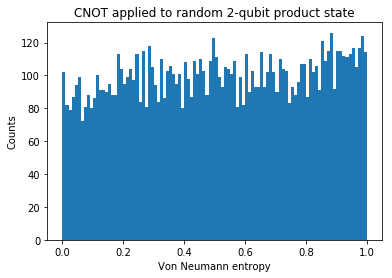

In [153]:
plt.hist(entropies_CNOT, bins = 100);
plt.xlabel('Von Neumann entropy')
plt.ylabel('Counts')
plt.title('CNOT applied to random 2-qubit product state');

Interesting.  So part of my guess (that the entanglement of this ensemble would be lower than that of a Haar-random ensemble) was wrong, but another part (the fact that the distribution of entropies does not match) was right.  What about the average entropy in this case?

In [155]:
np.mean(entropies_CNOT)

0.51893221898097963

So it looks like the average entropy of a CNOT applied to a random product state is roughly the same as the average entropy of a Haar-random 2-qubit state, though the distributions of entanglement are different.

### Qubit entangled with an N-dimensional system: von Neumann entropy distribution

We saw above the distribution of von Neumann entropy for a pure state of two qubits.  We'd expect that entropy distribution to shift to higher and higher values as the dimension of the second system increases.  Let's see this in action. 

In [182]:
n_random_states = 10000
dim_sys1 = 2
dim_sys2 = 3

bin_edges = np.linspace(0,1,100)
bin_centers = (bin_edges + 0.005)[:-1]
qubit_entropy_distribution = {}

dim_sys2_array = [2,4,10]

for dim_sys2 in dim_sys2_array:
    entropies_temp = np.zeros(n_random_states)

    for i in range(n_random_states):
        psi = ST.random_pure_state(dim_sys1*dim_sys2)
        rho = ST.vec_to_dm(psi)
        rho_reduced = ST.partial_trace(rho, dim = [dim_sys1, dim_sys2])
        entropies_temp[i] = ST.entropy(rho_reduced)
        
        qubit_entropy_distribution[dim_sys2] = np.histogram(entropies_temp, bins = bin_edges, normed = True)[0]

Text(0,0.5,'Counts')

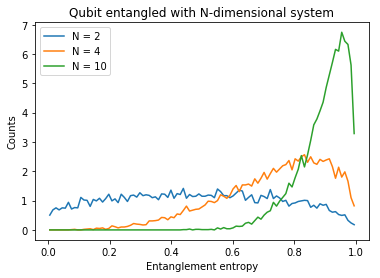

In [185]:
for j in dim_sys2_array:
    plt.plot(bin_centers,qubit_entropy_distribution[j], label = 'N = {}'.format(j))
plt.legend(loc = 2)
plt.title('Qubit entangled with N-dimensional system')
plt.xlabel('Entanglement entropy')
plt.ylabel('Counts')

Interesting that it goes down at the end, i.e. the volume of space which leads to maximally mixed states is lower than that which leads to almost maximally mixed states.  I feel like there should be an easy parameterization of maximally mixed states (since they have to trace out to exactly the identity on the other system), but I can't think of one.  Maybe something like $|0\rangle$, entangled with a random pure state on the other system, plus $|1\rangle$, entangled with an orthogonal random pure state on the other system.  But how to ensure the other state is orthogonal?

But that won't do it, you should really replace $|0\rangle$ and $|1\rangle$ above with a random qubit pure state and then its orthogonal state, which at least for a qubit is easy to do.  

## Do the Gell-Mann matrices form a Unitary 1-design?

A unitary 1-design is a probability distribution over quantum states, such that averaging over that probability distribution of $|\psi\rangle \langle \psi |$ is equivalent to an integration over the Haar measure.  

See [https://en.wikipedia.org/wiki/Quantum_t-design#Unitary_Designs]

Clearly the answer was NO, and I could've realized that without doing all this work b/c the Gell-Mann matrices aren't even unitary. Whoops

In [4]:
dim_sys = 3 # work with qutrits

In [5]:
def random_pure_state(dim = 2):
    x = np.random.randn(2*dim)
    norm_x = np.linalg.norm(x, ord = 2)
    normalized_x = x/norm_x
    
    return np.matrix(normalized_x[:dim] + 1j*normalized_x[dim:]).T

In [6]:
n_randomizations = 10000
sys_dim = 3

avg_projector = np.zeros((sys_dim,sys_dim))
for n in np.arange(n_randomizations):
    psi = random_pure_state(sys_dim)
    psi_projector = psi*psi.getH()
    
    avg_projector = avg_projector + psi_projector
avg_projector = avg_projector / n_randomizations

In [7]:
np.round(avg_projector,2)

matrix([[ 0.33+0.j, -0.  -0.j,  0.  -0.j],
        [-0.  +0.j,  0.34+0.j,  0.01+0.j],
        [ 0.  +0.j,  0.01-0.j,  0.33+0.j]])

In [8]:
Gell_Mann_matrices = [
np.matrix([[0,1,0],[1,0,0],[0,0,0]], dtype = 'complex'),
np.matrix([[0,-1j,0],[1j,0,0],[0,0,0]], dtype = 'complex'),
np.matrix([[1,0,0],[0,-1,0],[0,0,0]], dtype = 'complex'),
np.matrix([[0,0,1],[0,0,0],[1,0,0,]], dtype = 'complex'),
np.matrix([[0,0,-1j],[0,0,0],[1j,0,0]], dtype = 'complex'),
np.matrix([[0,0,0],[0,0,1],[0,1,0]], dtype = 'complex'),
np.matrix([[0,0,0],[0,0,-1j],[0,1j,0]], dtype = 'complex'),
np.sqrt(1./3)*np.matrix(np.diag([1,1,-2]), dtype = 'complex'),
np.matrix(np.eye(3))
]

In [11]:
psi = random_pure_state(dim = 3)

avg_projector = np.zeros((sys_dim,sys_dim))
for mat in Qutrit_ops:
    matpsi = mat*psi
    matpsi_projector = matpsi*matpsi.getH()
    
    avg_projector = avg_projector + matpsi_projector
avg_projector = avg_projector / len(Gell_Mann_matrices)

In [12]:
np.round(avg_projector,2)

matrix([[ 0.33+0.j, -0.  +0.j, -0.  -0.j],
        [-0.  -0.j,  0.33+0.j, -0.  +0.j],
        [-0.  +0.j, -0.  -0.j,  0.33+0.j]])

In [13]:
len(Gell_Mann_matrices)

9

In [10]:
omega = np.exp(2*np.pi*1j/3)

X = np.matrix([[0,0,1],[1,0,0],[0,1,0]])
Z = np.matrix(np.diag([1, omega, omega*omega]))
Y = X*Z
V = X*Z*Z

Qutrit_ops = [
    np.matrix(np.eye(3), dtype = 'complex'),
    Z, 
    X, 
    Y, 
    V, 
    Z*Z,
    X*X,
    Y*Y,
    V*V,
]

In [16]:
verbose = False

U_scramble = np.matrix([[1,0,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0,0,1],
                        [0,0,0,0,1,0,0,0,0],
                        [0,0,0,0,0,1,0,0,0],
                        [0,1,0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,1,0,0],
                        [0,0,0,0,0,0,0,1,0],
                        [0,0,0,1,0,0,0,0,0],
                        [0,0,1,0,0,0,0,0,0],
                       ])

total_trace = 0

n_ops = 0
for vind, V in enumerate(Qutrit_ops):
    for wind, W in enumerate(Qutrit_ops):
        V2 = np.matrix(np.kron(V,np.eye(3)))
        W2 = np.matrix(np.kron(np.eye(3), W))
        
        indiv_trace = np.trace((V2.getH() * (U_scramble * W2* U_scramble.getH()).getH() * V2 * (U_scramble * W2 * U_scramble.getH()))/9.) 
        if verbose:
            print(vind, wind, indiv_trace)
        total_trace += indiv_trace
        
        n_ops += 1
        
total_trace = total_trace / n_ops

In [34]:
reload(ST)
ST.OTOC(np.matrix(np.eye(9)), Qutrit_ops)

(1+1.827527612551687e-18j)

In [19]:
def permutation_matrix(permutation):
    """ Given a permutation, generates a permutation matrix from that permutation"""
    
    permutation = np.array(permutation)
    
    n_elem = len(permutation)
    
    # verify that the permutation contains elements from 0 to len(permutation) - 1, inclusive
    assert np.all(sorted(permutation) - np.arange(n_elem) == np.zeros(len(permutation)))
    
    matrix_to_return = np.zeros((n_elem, n_elem))
    
    for ind, elem in enumerate(permutation):
        matrix_to_return[elem, ind] = 1
        
    return np.matrix(matrix_to_return)

In [ ]:
def Hadamard_to_identity(alpha):
    """ returns a single-qutrit unitary matrix which
    smoothly interpolates between the Hadamard gate and the identity gate
    When alpha is unity, it is the Hadamard
    When alpha is zero, it is the identity
    """
    
    U1 = 
    
    ['EFY-90'],
    ['X90'],
    ['Z-109.471'],
    ['EFZ54.7355'],
    ['X-90'],
    ['Z180'],
    ['EFZ-90'],
    ['EFY90'],
    